In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy

In [2]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [50]:
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T

def props_chooser(T, T_rep, process = 'heating'):
    if (T_rep<1268 and process == 'heating') or (T_rep<=1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'alpha'),cp_Ti(T,phase = 'alpha'),k_Ti(T,phase = 'alpha')
    elif (T_rep<1928 and process == 'heating') or (T_rep>1073 and process == 'cooling'):
        return rho_Ti(T,phase = 'beta'),cp_Ti(T,phase = 'beta'),k_Ti(T,phase = 'beta')
    elif (T_rep>=1928 and process == 'heating') or (T_rep>=1878 and process == 'cooling'):
        return rho_Ti(T,phase = 'liquid'),cp_Ti(T,phase = 'liquid'),k_Ti(T,phase = 'liquid')
    else:
        return -1
    

In [115]:
class FEM:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,centre,theta_prev_time = None,theta_prev_pic = None,mode = "linear",verbose = False):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = -1e-3   # W/mm^2
        c = 658 #J/kg.K
        rho = 7.6e-6 #kg/mm^3
        kappa = 0.025 #W/mm.K
        ro = 2 #mm
        vo = 2 #mm/s
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        G = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        h = []
        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            area = 0
            if mode == "non_linear":
                T_rep = np.mean(theta_prev_time[np.ix_(econ,[0])]) #temperature at the centroid of the element
                # print(T_rep)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]

                if mode == "non_linear":
                    rhos,cs,ks = props_chooser(theta_prev_pic[np.ix_(econ,[0])],T_rep)
                    # ks,rhos,cs = k_Ti(theta_prev_time[np.ix_(econ,[0])],phase = 'alpha'),\
                    #             rho_Ti(theta_prev_time[np.ix_(econ,[0])],phase = 'alpha'),\
                    #             cp_Ti(theta_prev_time[np.ix_(econ,[0])],phase = 'alpha')
                    kappa = N@ks/1e3 ##m to mm
                    rho = N@rhos/1e9  ##m to mm
                    c = N@cs
                K[np.ix_(econ,econ)] += kappa*a
                G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X,centre,ro)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T
                area += np.linalg.det(Jac)*weights[j]
            h.append(area)

            for l,m in zip([0,1,2],[1,2,0]):
                n1 = econ[l]
                n2 = econ[m]
                check_rn = (n1 in rn and n2 in rn)
                check_tn = (n1 in tn and n2 in tn)
                check_bn = (n1 in bn and n2 in bn)
                if check_rn or check_tn or check_bn:
                    # print(n1,'\t',n2)
                    line_gp = 3
                    line_ips = np.array(self.data_line["ips"][line_gp])
                    line_weights = np.array(self.data_line["weights"][line_gp])
                    for k,ipk in enumerate(line_ips):
                        N_line = np.array([(1-ipk)/2, (1+ipk)/2]).reshape(1,-1)
                        dN_line = np.array([-1/2, 1/2]).reshape(1,-1)
                        line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #assuming interfacial lines are along x axis
                        Jac_line = np.matmul(dN_line,line_boundary)
                        if np.linalg.det(Jac_line)<0:
                            n1,n2 = n2,n1
                            line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #interchanging nodes"
                            Jac_line = np.matmul(dN_line,line_boundary)
                        # print(np.linalg.det(Jac_line))
                        boundary_term[np.ix_([n1,n2],[0])] += N_line.T*np.linalg.det(Jac_line)*(-qo)*line_weights[k]
        if verbose == True:
            print(f"Mesh size is {np.sqrt(np.mean(h))}")
            print(f"Spot radius is {ro}")
        T_l = 273+20
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]+G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        theta_sub = np.linalg.inv(K_sub+G_sub)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [K,G,F,boundary_term,theta]


In [116]:
soln1 = FEM()

In [87]:
mesh_size_factor = 2

In [88]:
filename = f"rectangle_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
K,G,F,boundary,theta = soln1.fit_ele(nodecoords,ele_con,np.array([[50,25]]),verbose = True)

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932

Mesh size is 1.3058792441389253
Spot radius is 2


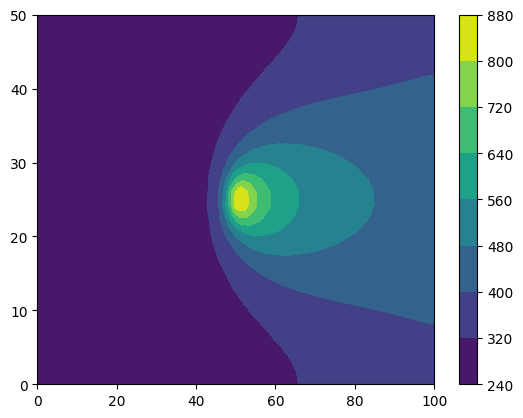

In [89]:
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten())
plt.colorbar()
plt.show()

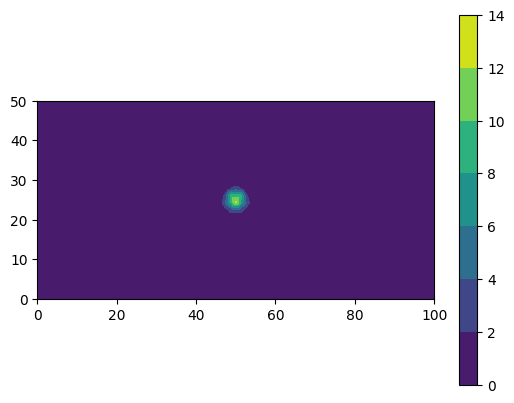

In [90]:
### Plotting the gaussian
plt.tricontourf(nodecoords[:,0],nodecoords[:,1], F.flatten())
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

## Picard iteration for moving source heat conduction

In [113]:
def picard(nodecoords,ele_con,theta_init,source):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,theta_new = soln2.fit_ele(nodecoords,ele_con,source,theta_prev_time = theta_init,theta_prev_pic = theta_old,mode = "non_linear")
        e = np.linalg.norm(theta_new - theta_old)
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")
        # print(theta_init)

    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten())
    plt.title(f"Converged solution after {iter} iterations")
    plt.colorbar()
    plt.show()

    return theta_new
        
        

Time is 0 seconds
Error at 1 iteration is 3.47E+04
Error at 2 iteration is 3.36E+03
Error at 3 iteration is 5.65E+02
Error at 4 iteration is 1.50E+02
Error at 5 iteration is 3.65E+01
Error at 6 iteration is 8.52E+00
Error at 7 iteration is 2.10E+00
Error at 8 iteration is 5.25E-01
Error at 9 iteration is 1.21E-01
Error at 10 iteration is 2.87E-02
Error at 11 iteration is 6.96E-03
Error at 12 iteration is 1.56E-03
Error at 13 iteration is 3.58E-04
Error at 14 iteration is 8.35E-05


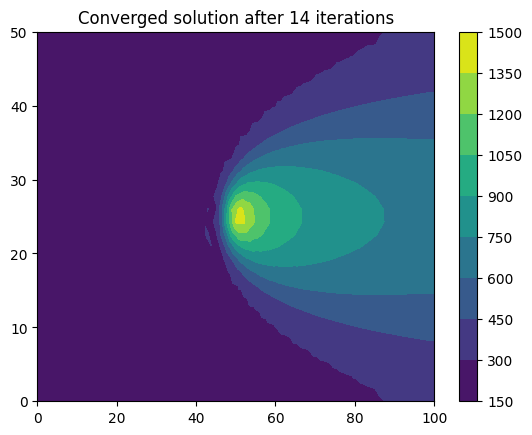

Time is 1 seconds
Error at 1 iteration is 1.96E+03
Error at 2 iteration is 4.98E+02
Error at 3 iteration is 7.04E+01
Error at 4 iteration is 1.83E+01
Error at 5 iteration is 2.23E+00
Error at 6 iteration is 5.18E-01
Error at 7 iteration is 6.04E-02
Error at 8 iteration is 1.33E-02
Error at 9 iteration is 1.52E-03
Error at 10 iteration is 3.25E-04
Error at 11 iteration is 3.70E-05


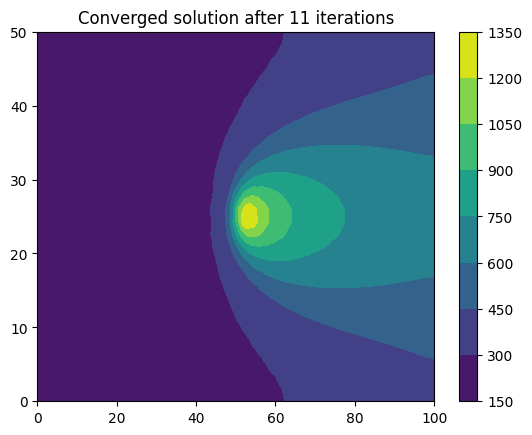

Time is 2 seconds
Error at 1 iteration is 1.25E+03
Error at 2 iteration is 5.31E+02
Error at 3 iteration is 6.18E+01
Error at 4 iteration is 1.52E+01
Error at 5 iteration is 1.59E+00
Error at 6 iteration is 3.47E-01
Error at 7 iteration is 3.55E-02
Error at 8 iteration is 7.20E-03
Error at 9 iteration is 7.44E-04
Error at 10 iteration is 1.42E-04
Error at 11 iteration is 1.53E-05


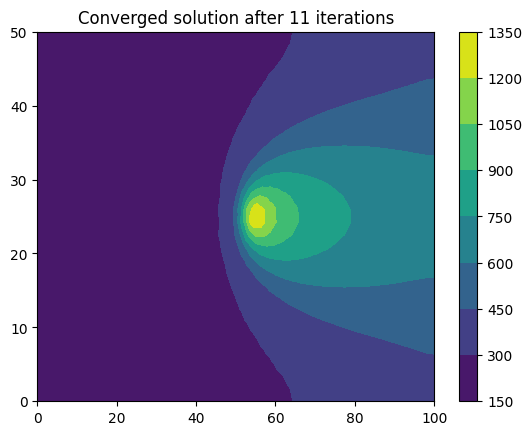

Time is 3 seconds
Error at 1 iteration is 1.22E+03
Error at 2 iteration is 5.20E+02
Error at 3 iteration is 6.08E+01
Error at 4 iteration is 1.42E+01
Error at 5 iteration is 1.50E+00
Error at 6 iteration is 3.15E-01
Error at 7 iteration is 3.23E-02
Error at 8 iteration is 6.33E-03
Error at 9 iteration is 6.52E-04
Error at 10 iteration is 1.21E-04
Error at 11 iteration is 1.28E-05


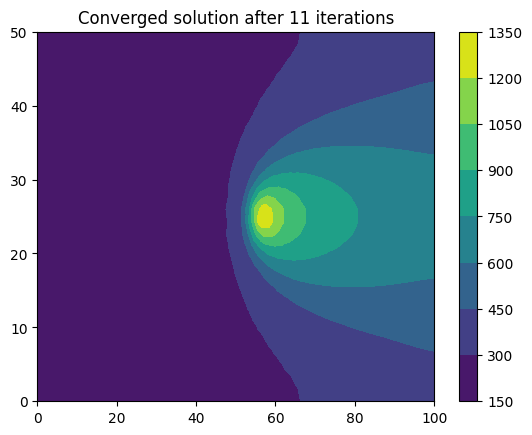

Time is 4 seconds
Error at 1 iteration is 1.21E+03
Error at 2 iteration is 5.12E+02
Error at 3 iteration is 6.01E+01
Error at 4 iteration is 1.39E+01
Error at 5 iteration is 1.48E+00
Error at 6 iteration is 3.08E-01
Error at 7 iteration is 3.19E-02
Error at 8 iteration is 6.18E-03
Error at 9 iteration is 6.44E-04
Error at 10 iteration is 1.18E-04
Error at 11 iteration is 1.27E-05


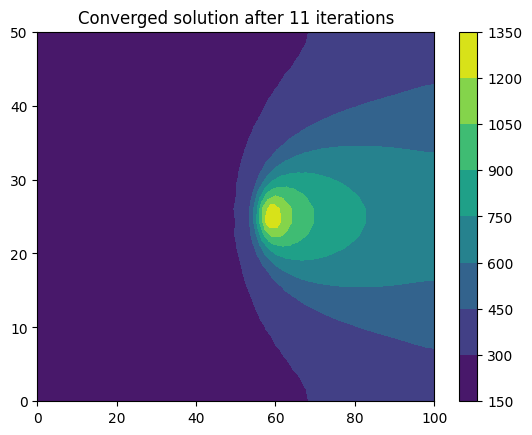

Time is 5 seconds
Error at 1 iteration is 1.21E+03
Error at 2 iteration is 5.05E+02
Error at 3 iteration is 5.96E+01
Error at 4 iteration is 1.37E+01
Error at 5 iteration is 1.46E+00
Error at 6 iteration is 3.01E-01
Error at 7 iteration is 3.15E-02
Error at 8 iteration is 6.04E-03
Error at 9 iteration is 6.37E-04
Error at 10 iteration is 1.15E-04
Error at 11 iteration is 1.25E-05


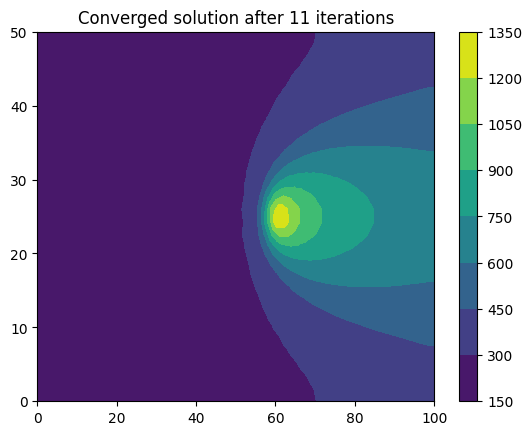

Time is 6 seconds
Error at 1 iteration is 1.21E+03
Error at 2 iteration is 4.98E+02
Error at 3 iteration is 5.90E+01
Error at 4 iteration is 1.34E+01
Error at 5 iteration is 1.44E+00
Error at 6 iteration is 2.94E-01
Error at 7 iteration is 3.11E-02
Error at 8 iteration is 5.89E-03
Error at 9 iteration is 6.29E-04
Error at 10 iteration is 1.12E-04
Error at 11 iteration is 1.24E-05


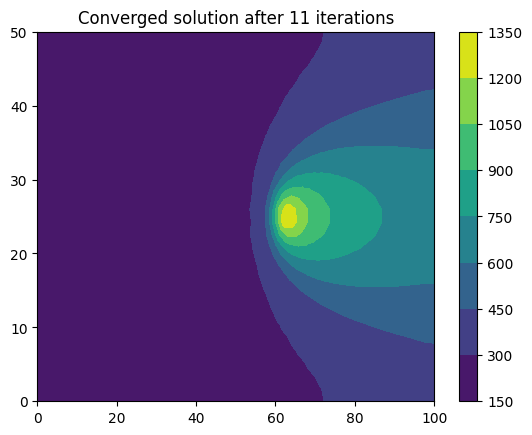

Time is 7 seconds
Error at 1 iteration is 1.20E+03
Error at 2 iteration is 4.91E+02
Error at 3 iteration is 5.85E+01
Error at 4 iteration is 1.31E+01
Error at 5 iteration is 1.43E+00
Error at 6 iteration is 2.87E-01
Error at 7 iteration is 3.08E-02
Error at 8 iteration is 5.73E-03
Error at 9 iteration is 6.22E-04
Error at 10 iteration is 1.09E-04
Error at 11 iteration is 1.22E-05


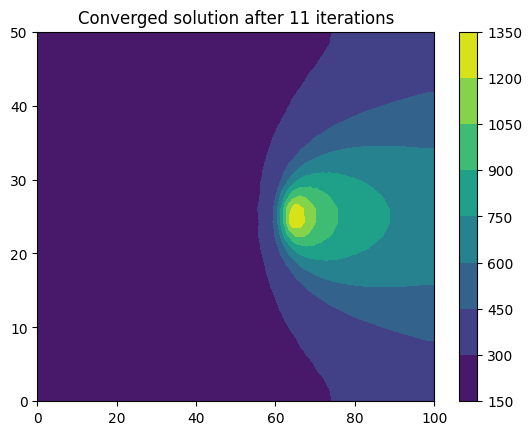

Time is 8 seconds
Error at 1 iteration is 1.20E+03
Error at 2 iteration is 4.83E+02
Error at 3 iteration is 5.80E+01
Error at 4 iteration is 1.28E+01
Error at 5 iteration is 1.41E+00
Error at 6 iteration is 2.79E-01
Error at 7 iteration is 3.04E-02
Error at 8 iteration is 5.57E-03
Error at 9 iteration is 6.14E-04
Error at 10 iteration is 1.06E-04
Error at 11 iteration is 1.21E-05


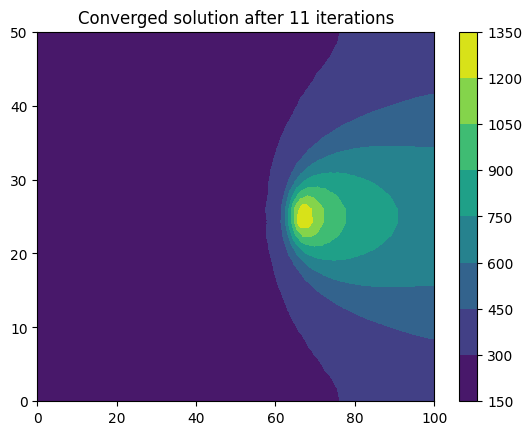

Time is 9 seconds
Error at 1 iteration is 1.20E+03
Error at 2 iteration is 4.75E+02
Error at 3 iteration is 5.75E+01
Error at 4 iteration is 1.24E+01
Error at 5 iteration is 1.39E+00
Error at 6 iteration is 2.71E-01
Error at 7 iteration is 2.99E-02
Error at 8 iteration is 5.40E-03
Error at 9 iteration is 6.05E-04
Error at 10 iteration is 1.02E-04
Error at 11 iteration is 1.19E-05


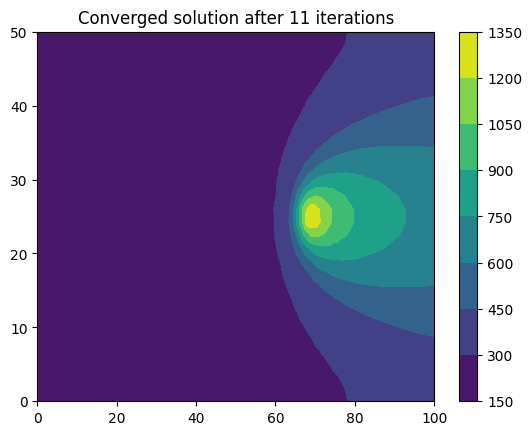

In [118]:
soln2 = FEM()
T_l = 273+1000
t_final = 10
times = np.arange(0,t_final,1)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 50
for time in times:
    print(f"Time is {time} seconds")
    theta_final = picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source+2*time,25]]))
    theta_prev = theta_final

In [97]:
np.max(theta_final)

np.float64(1296.181372731935)

## Picard iteration validation

In [13]:
def Q(point):
    x = point[0,0] #in mm
    return 15e-3*(x/100)*(1-x/100) ## W/mm^3

def k_T(T):
    # return np.ones_like(T)*110
    return (100+0.004*(T-50-273)**2)*1e-3  ##W/mmK

In [14]:
class Picard_valid:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,dt,theta_prev_time = None,theta_prev_pic = None,mode = "linear",scheme = "implicit"):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = 0   # W/mm^2
        c = 465 #J/kg.K
        rho = 7e-6 #kg/mm^3
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        M = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodes[:,0] == 0)[0]
        rn = np.where(nodes[:,0] == np.max(nodes[:,0]))[0]
        bn = np.where(nodes[:,1] == 0)[0]
        tn = np.where(nodes[:,1] == np.max(nodes[:,1]))[0]

        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]
                m = np.matmul(N.T,N)*np.linalg.det(Jac)*weights[j]
                if mode == "non_linear":
                    kappa = N@k_T(theta_prev_pic[np.ix_(econ,[0])])
                K[np.ix_(econ,econ)] += kappa*a
                M[np.ix_(econ,econ)] += rho*c*m
                # G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T


        T_b = 273+100
        non_bn = np.setdiff1d(np.arange(K.shape[0]),bn)
        rhs = (F+boundary_term+M@theta_prev_time/dt)\
               -T_b*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_bn,non_bn)]
        M_sub = M[np.ix_(non_bn,non_bn)]
        rhs_sub = rhs[np.ix_(non_bn,[0])]
        # print(K_sub)
        # print(np.sum(M_sub))
        # print(K_sub+M_sub/dt)
        # print("inverter:",np.sum(np.linalg.inv(K_sub+M_sub/dt)))
        # print("multiplier:",np.sum(((F+boundary_term+M@(theta_prev_time-273)/dt)\
        #        -(T_b-273)*np.sum(K[np.ix_(np.arange(K.shape[0]),bn)]+M[np.ix_(np.arange(K.shape[0]),bn)]/dt,axis = 1).reshape(-1,1))[np.ix_(non_bn,[0])]))
        # return
        theta_sub = np.linalg.inv(K_sub+M_sub/dt)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_b
        theta[non_bn,:] = theta_sub.reshape(-1,1)
        
        return [M,K,F,boundary_term,theta]

In [15]:
def picard(soln,nodecoords,ele_con,theta_init):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes

    dt = 1
    times = np.arange(0,10,dt)
    theta_prev_time = theta_init
    
    for t in times:
        if t == round(t):
            print(np.min(theta_prev_time)-273,' at ',nodecoords[np.argmin(theta_prev_time)])
            print(np.max(theta_prev_time)-273,' at ',nodecoords[np.argmax(theta_prev_time)])
        e = 1e5
        tolerance = 1e-4
        iter = 0
        theta_prev_pic = theta_prev_time
        while(e>tolerance):
            iter +=1
            ## Implicit formulation 
            M,K,F,boundary_term,theta_new = soln.fit_ele(nodecoords,ele_con,dt,theta_prev_time = theta_prev_time,theta_prev_pic = theta_prev_pic,mode = "non_linear",scheme = "implicit")
            # print("M:",np.sum(M))
            # print("K:",np.sum(K))
            # print("F:",np.sum(F))
            # print("boundary_term:",np.sum(boundary_term))
            e = np.linalg.norm(theta_new - theta_prev_pic)
            theta_prev_pic = theta_new
            if t == round(t):
                print(f"Error at {iter} iteration at time {t} is {e:.2E}")
        # print(np.any(boundary_term))  confirmation that b.t isn't contributing
        theta_prev_time = theta_new
        
    plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta_new.flatten()-273, cmap = 'plasma')
    plt.title(f"Converged solution")
    plt.colorbar()
    plt.show()

    return theta_new
        

In [16]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1

Reading square_3.msh
Number of nodes in the mesh: 380
Number of triangles in the mesh: 690



50.0  at  [100. 100.   0.]
50.0  at  [100. 100.   0.]
Error at 1 iteration at time 0 is 2.34E+02
Error at 2 iteration at time 0 is 3.52E+00
Error at 3 iteration at time 0 is 3.69E-02
Error at 4 iteration at time 0 is 2.79E-04
Error at 5 iteration at time 0 is 1.79E-06
50.21715085157712  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 1 is 6.46E+01
Error at 2 iteration at time 1 is 4.82E-01
Error at 3 iteration at time 1 is 2.65E-03
Error at 4 iteration at time 1 is 1.24E-05
50.5384875579075  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 2 is 4.52E+01
Error at 2 iteration at time 2 is 2.56E-01
Error at 3 iteration at time 2 is 1.29E-03
Error at 4 iteration at time 2 is 1.17E-05
50.92924218714677  at  [100. 100.   0.]
100.0  at  [100.   0.   0.]
Error at 1 iteration at time 3 is 3.69E+01
Error at 2 iteration at time 3 is 1.62E-01
Error at 3 iteration at time 3 is 9.17E-04
Error at 4 iteration at time 3 is 8.05E-06
51.372609065

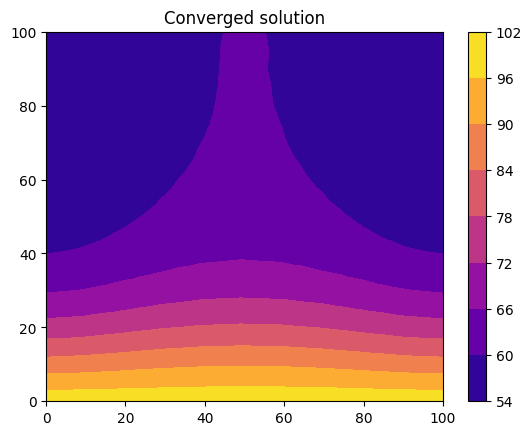

In [17]:
soln3 = Picard_valid()
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard(soln3,nodecoords,ele_con,theta_init)

In [18]:
#at node a
theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273

array([54.74332597])

In [19]:
#at node b
theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273

array([54.74224726])